In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('data_full_5sekres.xlsx')

In [3]:
df1 = df.copy()

In [124]:
#Create a column of load profile
df1['Load'] = df1['thrusterAndPropulsion']
df1['BaseLoad'] = 300
df1['Load'] = df1['thrusterAndPropulsion'] + df1['BaseLoad']

df1['Battery'] = 0
df1['SOC'] = 0
#Create dataset with only relevant columns
df3 = df1[['datetime', 'Load', 'engMdoPower_0_','engMdoPower_1_','engMdoPower_2_', 'engMdoPower_3_', 'operationId', 'BaseLoad', 'Battery', 'SOC']]

#Set engine powers to zero
num = df3['engMdoPower_0_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_1_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_2_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_3_']._get_numeric_data()
num[num != 0] = 0


display(df3)

,datetime,Load,engMdoPower_0_,engMdoPower_1_,engMdoPower_2_,engMdoPower_3_,operationId,BaseLoad,Battery,SOC
0,2020-01-30 00:00:00,300.0,0.0,0.0,0,0.0,6.0,300,0,0
1,2020-01-30 00:00:05,300.0,0.0,0.0,0,0.0,6.0,300,0,0
2,2020-01-30 00:00:10,300.0,0.0,0.0,0,0.0,6.0,300,0,0
3,2020-01-30 00:00:15,300.0,0.0,0.0,0,0.0,6.0,300,0,0
4,2020-01-30 00:00:20,300.0,0.0,0.0,0,0.0,6.0,300,0,0
...,...,...,...,...,...,...,...,...,...,...
120955,2020-02-05 23:59:35,1796.0,0.0,0.0,0,0.0,3.0,300,0,0
120956,2020-02-05 23:59:40,1743.2,0.0,0.0,0,0.0,3.0,300,0,0
120957,2020-02-05 23:59:45,1725.6,0.0,0.0,0,0.0,3.0,300,0,0
120958,2020-02-05 23:59:50,1760.8,0.0,0.0,0,0.0,3.0,300,0,0


# Ramp and peak shaving

In [108]:
df2 = df3.copy()

load = df2['Load'].values
dg0 = df2['engMdoPower_0_'].values
dg1 = df2['engMdoPower_1_'].values
dg2 = df2['engMdoPower_2_'].values
dg3 = df2['engMdoPower_3_'].values
bat = df2['Battery'].values
soc = df2['SOC'].values
soc[0:100] = 496 #124 empty
#soc[10] = 496
opid = df2['operationId'].values

for i in range(len(load)):
    if i <= 5:
        pass
    elif i == 120959:
        pass
    elif load[i] <= 2100:
        if load[i]/load[i-2] > 1.5 or load[i] > 2000:
            if soc[i] > 124:
                bat[i] = 100
                soc[i+1] = soc[i] - (bat[i]/720)
                dg0[i] = load[i]-bat[i]
            else:
                dg0[i] = load[i]
                soc[i+1] = soc[i]
        else:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
    elif load[i] <= 4200:
        if load[i]/load[i-2] > 1.5 or load[i] > 4000:
            if soc[i] > 124:
                bat[i] = 100
                soc[i+1] = soc[i] - (bat[i]/720)
                dg0[i] = dg1[i] = (load[i]-bat[i])/2
            else:
                dg0[i] = dg1[i] = load[i]/2
                soc[i+1] = soc[i]
        else:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i] 
        

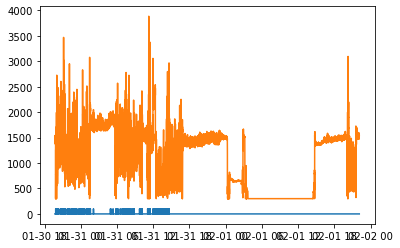

In [111]:
x = df2.iloc[14200:50500]['datetime']
plt.plot(x, bat[14200:50500])
plt.plot(x, load[14200:50500])
#plt.plot(x, dg0)

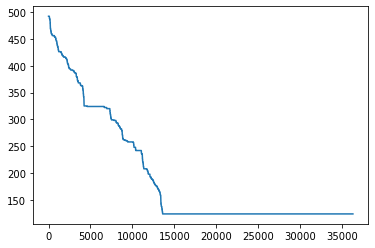

In [112]:
plt.plot(soc[14200:50500])

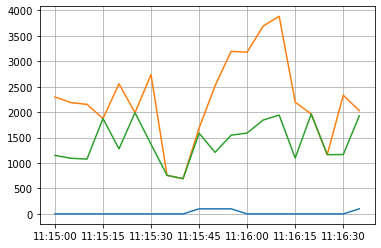

In [121]:
x = df2.iloc[25380:25400]['datetime']
plt.plot(x, bat[25380:25400])
plt.plot(x, load[25380:25400])
plt.plot(x, dg0[25380:25400], label = 'dg0')
plt.grid()

# Peak shaving

In [210]:
df4 = df3.copy()

load = df4['Load'].values
dg0 = df4['engMdoPower_0_'].values
dg1 = df4['engMdoPower_1_'].values
dg2 = df4['engMdoPower_2_'].values
dg3 = df4['engMdoPower_3_'].values
bat = df4['Battery'].values
soc = [0]*120960
soc[0] = 496 #124 empty
opid = df4['operationId'].values

for i in range(len(load)):
    if i == 120959:
        pass
    elif load[i] <= 2100 and load[i+1] <= 2100:
        if load[i] > 1900:
            if soc[i] > 124:
                bat[i] = 200
                soc[i+1] = soc[i] - (bat[i]/720)
                dg0[i] = load[i]-bat[i]
            else:
                dg0[i] = load[i]
                soc[i+1] = soc[i]
        elif load[i] < 840 and soc[i] < 496:
            dg0[i] = 840
            bat[i] = load[i] - dg0[i] 
            soc[i+1] = soc[i] - bat[i]/720
        else:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
    elif load[i] >= 2100 and load[i+1] < 2100:
        dg0[i] = dg1[i] = load[i]/2
        soc[i+1] = soc[i]
    elif load[i] <= 2100 and load[i+1] > 2100:
        dg0[i] = dg1[i] = load[i]/2
        soc[i+1] = soc[i]
    elif load[i] <= 4200:
        if load[i] > 3800:
            if soc[i] > 124:
                bat[i] = 400
                soc[i+1] = soc[i] - (bat[i]/720)
                dg0[i] = dg1[i] = (load[i]-bat[i])/2
            else:
                dg0[i] = dg1[i] = load[i]/2
                soc[i+1] = soc[i]
        else:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i] 

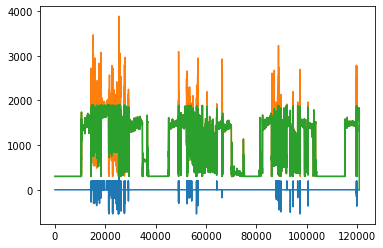

In [211]:
plt.plot(bat)
plt.plot(load)
plt.plot(dg0)

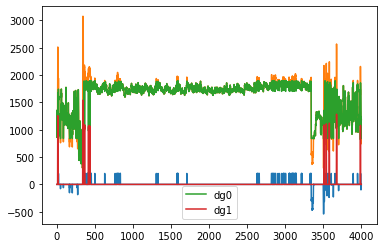

In [223]:
plt.plot(bat[18000:22000])
plt.plot(load[18000:22000])
plt.plot(dg0[18000:22000], label = 'dg0')
plt.plot(dg1[18000:22000], label = 'dg1')
plt.legend()

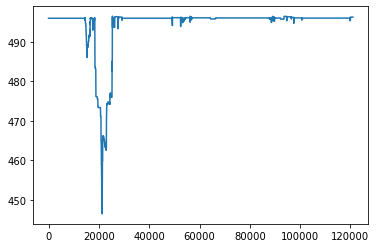

In [213]:
plt.plot(soc)